### Downloading libraries

In [167]:
import cv2
import skimage as ski
import numpy as np
from skimage import io

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage as ndi
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks

In [162]:
im = cv2.imread('lines.jpg', 0)

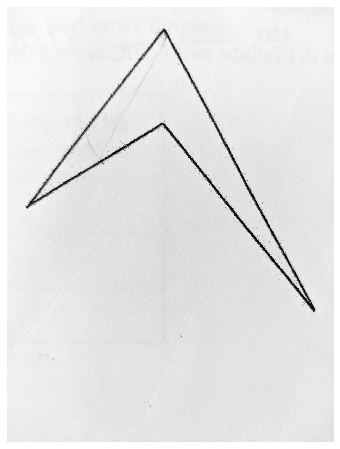

In [18]:
plt.figure(figsize=(12,8))
plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

### Let's use the in built method to find lines. We are first going to read the image as grayscale, you can perform gaussian smoothing over it to remove any noise(it helps to find better edges), though it's not required in our case. Then perform canny edge detection over it. Reason am not using OpenCV for this, well in OpenCV you will have to perform edge detection using either Laplacian or Sobel etc and then you pass this output to their canny method that in turn performs non-max suppression and hysteresis thresholding later. So why to bother yourself so much when there's a ready made one available via skimage.feature.

In [19]:
# Generate noisy image of a square
# im = ndi.gaussian_filter(im, 3)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=2)

In [20]:
# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 180)
h, theta, d = hough_line(edges2, theta=tested_angles)

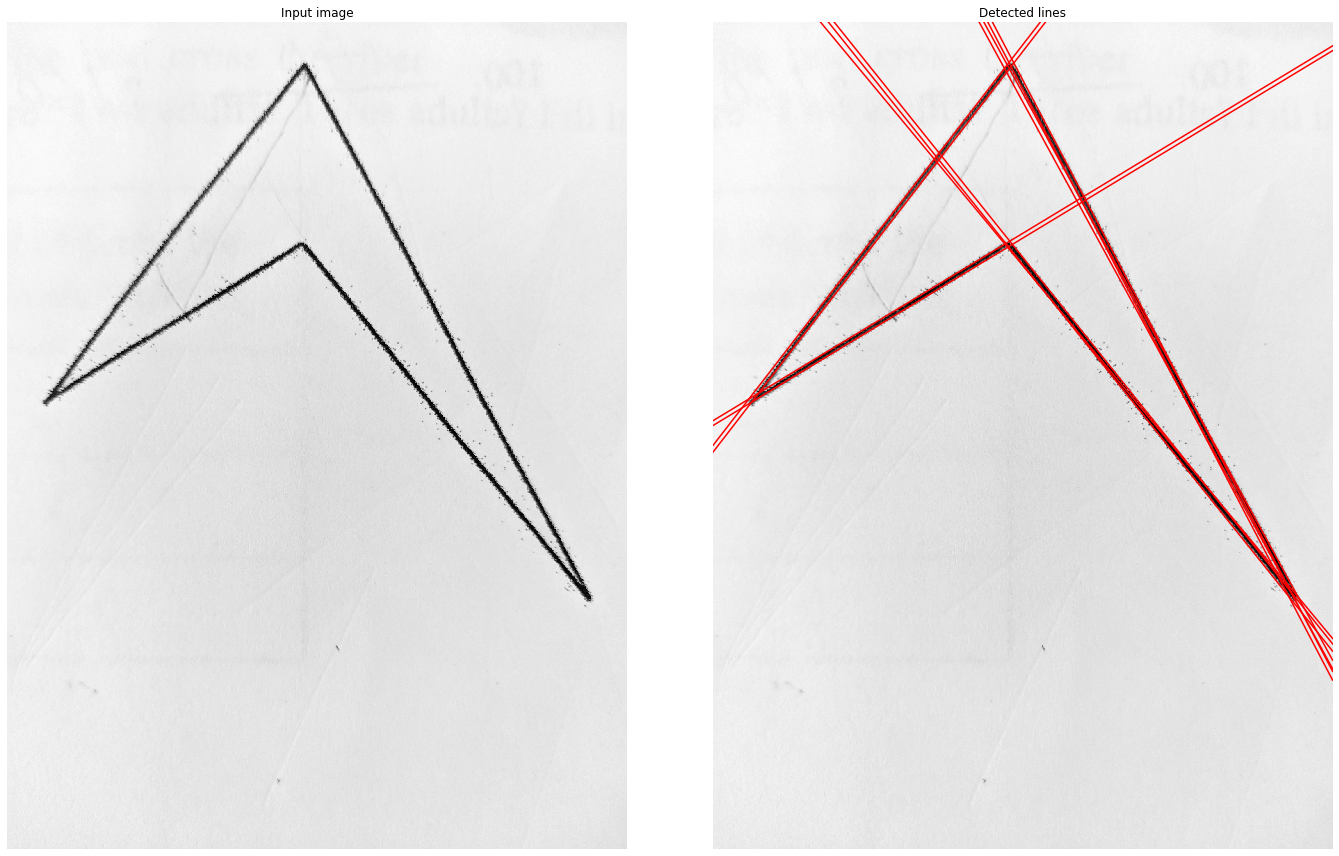

In [21]:
# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(20, 12))
ax = axes.ravel()

ax[0].imshow(im, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(im, cmap='gray')
origin = np.array((0, im.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r')
ax[1].set_xlim(origin)
ax[1].set_ylim((im.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

plt.tight_layout()
plt.show()

### Here's what the accumulator array looks like for this case

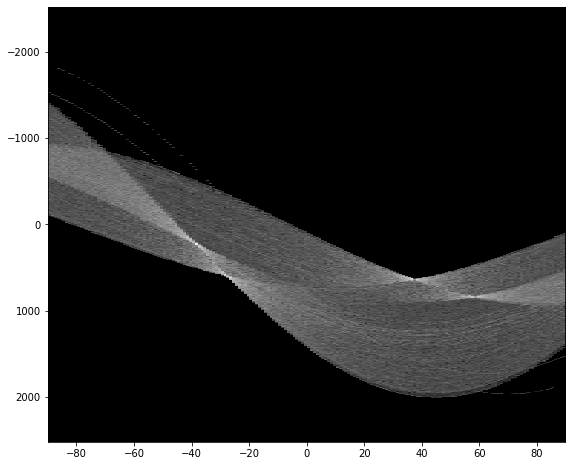

In [23]:
plt.figure(figsize=(12,8))
plt.imshow(np.log(1 + h), extent=[np.rad2deg(theta[0]), np.rad2deg(theta[-1]), d[-1], d[0]], aspect=0.03 , cmap= 'gray')

### Well the output is pretty much in front of you. And simple reason it shows multiple lines, well the line was pretty broad even after using canny. In fact I can use some morphological operations to decrease the broadness. Let's try that out:

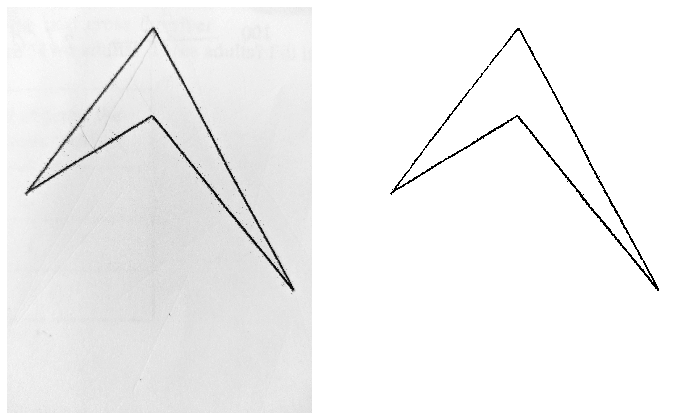

In [163]:
img = cv2.GaussianBlur(im, (3,3), 0)
ret,th = cv2.threshold(im,90,255, cv2.THRESH_BINARY)

plt.figure(figsize=(12,8))

plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(th, cmap='gray')
plt.axis('off')
plt.show()

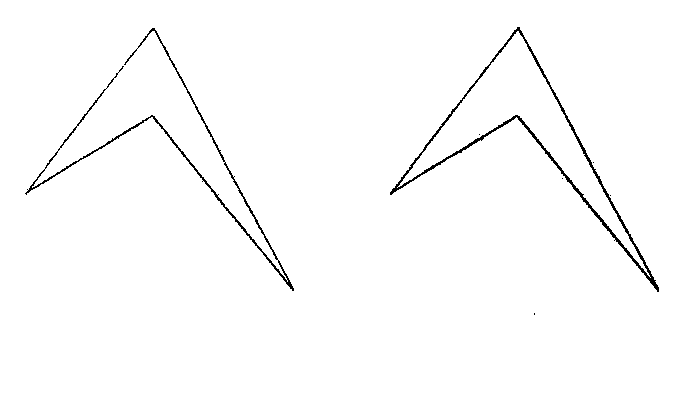

In [164]:
kernel = np.ones((3,3),np.uint8)

erosion = cv2.erode(th, kernel, iterations=1)

plt.figure(figsize=(12,8))

plt.subplot(121)
plt.imshow(th, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(erosion, cmap='gray')
plt.axis('off')
plt.show()

### Let's try same operation on this thresholded and binarized image:

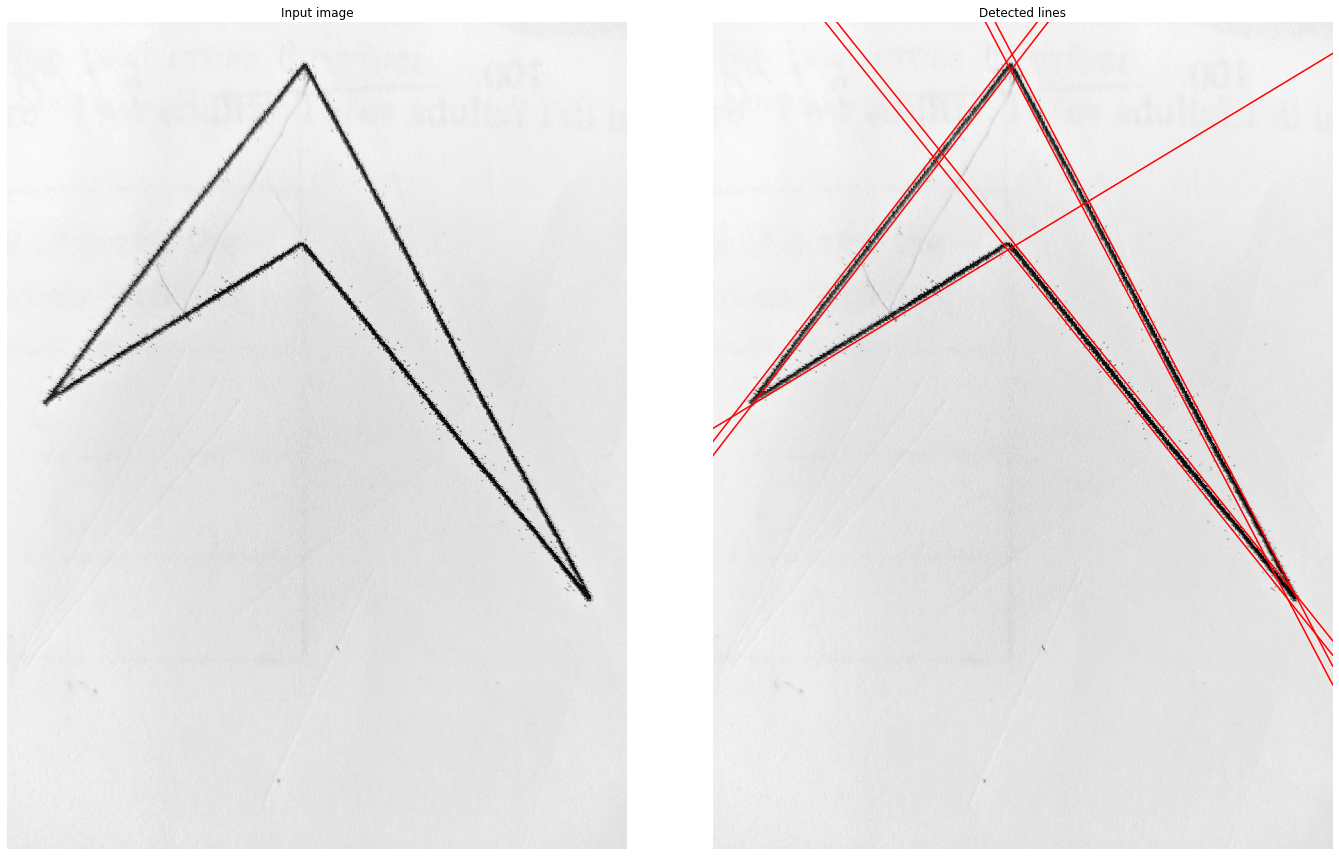

In [168]:
# Generate noisy image of a square
# im = ndi.gaussian_filter(im, 3)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(erosion)
edges2 = feature.canny(erosion, sigma=10)

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 180)
h, theta, d = hough_line(edges2, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(20, 12))
ax = axes.ravel()

ax[0].imshow(im, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(im, cmap='gray')
origin = np.array((0, im.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, threshold=350)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r')
ax[1].set_xlim(origin)
ax[1].set_ylim((im.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

plt.tight_layout()
plt.show()

### Bit better but well, we get the idea.

### Now we are going to create this same thing by ourself. Let's implement this ourselves

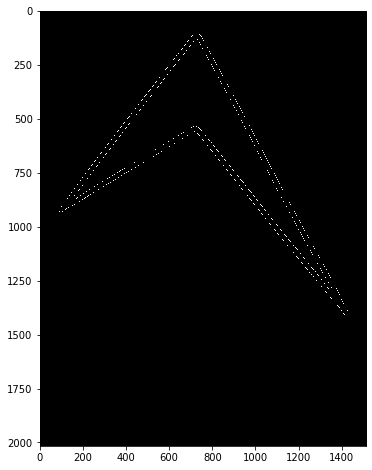

In [169]:
plt.figure(figsize=(12,8))
plt.imshow(edges2, 'gray')

### Always convert the image to floating type if you want to perform any operation on the values:

In [95]:
edges2 = edges2.astype('float16')

### Let's work with a very simple image first. Just two points, which we definitely know, that there will be a line that pass through them

### I am not going to go through the theory behind Hough Transform because it has been very well explained in so many videos and articles. You can go through some of them here:

[Link1](https://alyssaq.github.io/2014/understanding-hough-transform/)  
[Link2](https://towardsdatascience.com/lines-detection-with-hough-transform-84020b3b1549)

### We are going to work with multiple of 5 degrees to make our computations easier. The radians value can be easily obtained by following conversion of degrees to radians.

In [96]:
angles = np.radians(np.arange(-90, 95, 5))

print(angles)

[-1.57079633 -1.48352986 -1.3962634  -1.30899694 -1.22173048 -1.13446401
 -1.04719755 -0.95993109 -0.87266463 -0.78539816 -0.6981317  -0.61086524
 -0.52359878 -0.43633231 -0.34906585 -0.26179939 -0.17453293 -0.08726646
  0.          0.08726646  0.17453293  0.26179939  0.34906585  0.43633231
  0.52359878  0.61086524  0.6981317   0.78539816  0.87266463  0.95993109
  1.04719755  1.13446401  1.22173048  1.30899694  1.3962634   1.48352986
  1.57079633]


### Let's work with a very simple image first. Just two points, which we definitely know, that there will be a line that pass through them

In [204]:
twop= cv2.imread('two_points.jpg', 0)

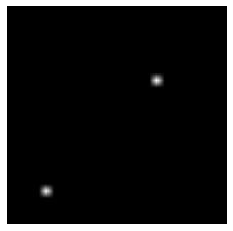

In [205]:
plt.figure(figsize=(6,4))
plt.imshow(twop, cmap='gray')
plt.axis('off')
plt.show()

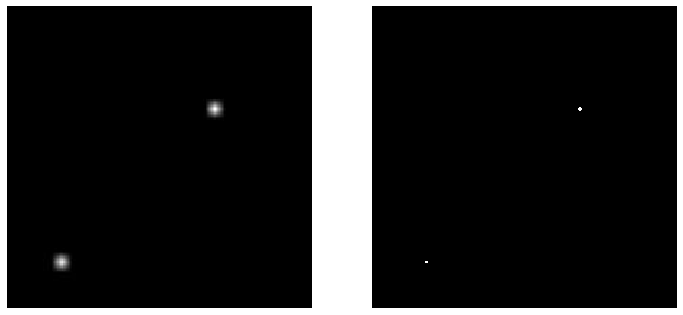

In [206]:
img = cv2.GaussianBlur(twop, (3,3), 0)
ret,th = cv2.threshold(img,90,255, cv2.THRESH_BINARY)

kernel = np.ones((3,3),np.uint8)

erosion = cv2.erode(th, kernel, iterations=2)

# There's no need of any edge detection in this case I believe

plt.figure(figsize=(12,8))

plt.subplot(121)
plt.imshow(twop, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(erosion, cmap='gray')
plt.axis('off')
plt.show()

In [166]:
def hough_line_func(img, angles):
    # Rho and Theta ranges
    wid, hgt = img.shape
    len_diag = int(np.ceil(np.sqrt(wid * wid + hgt * hgt)))   # max_dist
    distances = np.linspace(-len_diag, len_diag, len_diag * 2.0)

    # Cache some resuable values
    cos_t = np.cos(angles)
    sin_t = np.sin(angles)
    num_angles = len(angles)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * len_diag, num_angles), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_angles):
            # Calculate rho. diag_len is added for a positive index
            distance = int(round(x * cos_t[t_idx] + y * sin_t[t_idx]) + len_diag)
            accumulator[distance, t_idx] += 1

    return accumulator, distances

In [259]:
angles = np.radians(np.arange(-90, 91, 0.1))

In [260]:
out, dist = hough_line_func(erosion, angles)

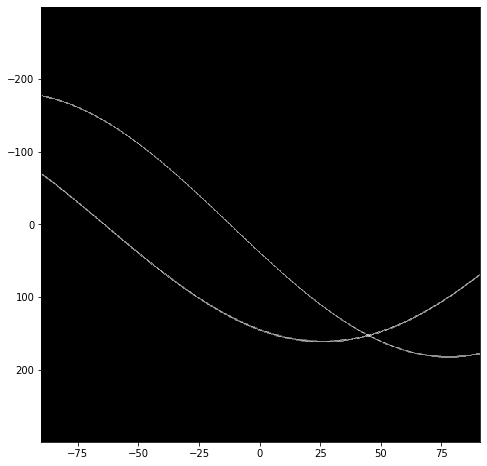

In [261]:
plt.figure(figsize=(12,8))
plt.imshow(np.log(1 + out), extent=[np.rad2deg(angles[0]), np.rad2deg(angles[-1]), dist[-1], dist[0]], aspect=0.3 , cmap= 'gray')

### Well we see that it was able to find the point where the two curves intersect, i.e. let's try drawing the line for point which has most voted values

In [266]:
# Here are all the unique voted values and their counts of each unique bins
print(np.unique(out, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6], dtype=uint64), array([1073244,    3336,    4457,    1335,       6,       1,       1],
      dtype=int64))


In [268]:
# Let's find out the theta and the rho value for our line's equation
# We added the diagonal length so that the accumulator matrix remains in bounds. We will now subtract same for value of rho
wid, hgt = erosion.shape
len_diag = int(np.ceil(np.sqrt(wid * wid + hgt * hgt)))

# Here's the value of the point with highest voted value in Hough Space
rho, theta = np.where(out==6)

rho-=len_diag
theta = angles[theta]

In [303]:
# Now let's generate two points from rho and theta values for plotting the line
# rho = x cos(theta) + y*sin(theta)
x1 = 0
y1 = int((rho - (x1 * np.cos(theta)))/np.sin(theta))

x2 = 210
y2 = int((rho - (x2 * np.cos(theta)))/np.sin(theta))

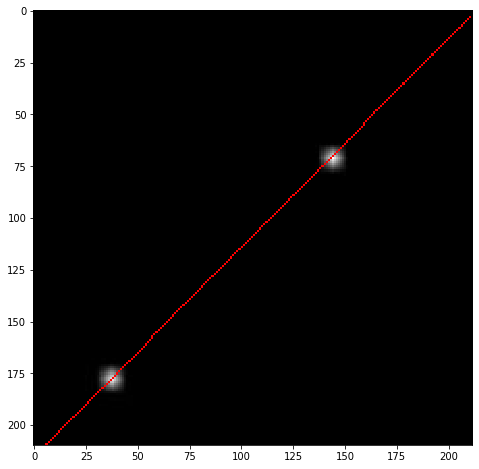

In [310]:
twop= cv2.imread('two_points.jpg')
cv2.line(twop, (x1,y1), (x2,y2), (255,0,0), thickness=1)
plt.figure(figsize=(14,8))
plt.imshow(twop, cmap='gray')

### Well, it does work right? Shall we try it with original image?

In [460]:
im = cv2.imread('lines.jpg', 0)

img = cv2.GaussianBlur(im, (3,3), 0)
ret,th = cv2.threshold(im,90,255, cv2.THRESH_BINARY)

kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(th, kernel, iterations=1)

edges1 = feature.canny(erosion)
edges2 = feature.canny(erosion, sigma=10)

In [461]:
edges2 = edges2.astype('float16')

angles = np.radians(np.arange(-90, 91, 1))

out, dist = hough_line_func(edges2, angles)

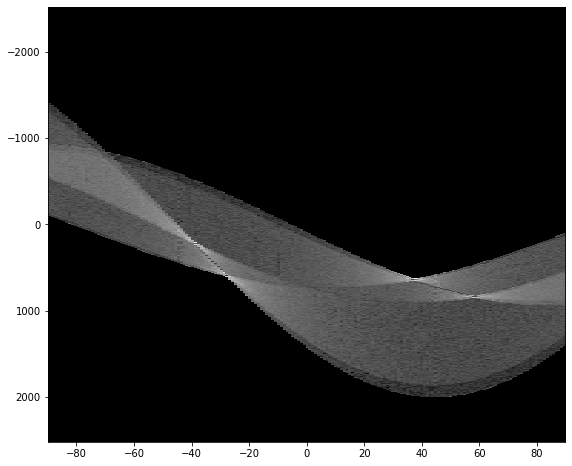

In [462]:
plt.figure(figsize=(12,8))
plt.imshow(np.log(1 + out), extent=[np.rad2deg(angles[0]), np.rad2deg(angles[-1]), dist[-1], dist[0]], aspect=0.03 , cmap= 'gray')

In [315]:
# Here are all the unique voted values and their counts of each unique bins
print(np.unique(out, return_counts=True))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 108, 109, 110, 111, 112, 114, 116, 117, 118, 119, 120,
       123, 125, 126, 129, 130, 134, 135, 136, 138, 139, 140, 141, 142,
       146, 151, 153, 156, 157, 159, 161, 163, 166, 175, 176, 180, 183,
       185, 186, 196, 197, 198, 199, 201, 202, 205, 207, 209, 210, 211,
       217, 223, 232, 243, 246, 248, 250, 251, 277, 278, 280, 283, 287,
       296, 297, 312, 322, 328, 330, 333, 381, 409, 428, 452],


### Well for our own sake, let's choose all the ones where number of votes are beyond 250.

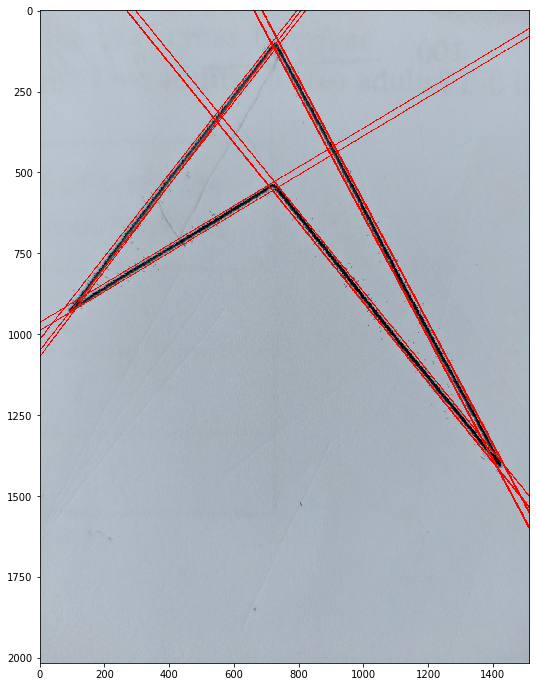

In [336]:
# Let's find out the theta and the rho value for our line's equation
# We added the diagonal length so that the accumulator matrix remains in bounds. We will now subtract same for value of rho
wid, hgt = edges2.shape
len_diag = int(np.ceil(np.sqrt(wid * wid + hgt * hgt)))

# Here's the value of the point with highest voted value in Hough Space
rhos, thetas = np.where(out>250)

im = cv2.imread('lines.jpg')
for r,t in zip(rhos,thetas):
    rho = r-len_diag
    theta = angles[t]
    
    x1 = 0
    y1 = int((rho - (x1 * np.cos(theta)))/np.sin(theta))

    x2 = im.shape[1]
    y2 = int((rho - (x2 * np.cos(theta)))/np.sin(theta))
    
    cv2.line(im, (x1,y1), (x2,y2), (255,0,0), thickness=2)
    
plt.figure(figsize=(20,12))
plt.imshow(im, cmap='gray')

### Now isn't that brilliant? Let's just end this with a nicely created function to just plot these lines:

In [478]:
def hough_lines_plot(img_path, accumulator, threshold, angles):
    img = cv2.imread(img_path)
    wid, hgt = img.shape[:2]
    len_diag = int(np.ceil(np.sqrt(wid * wid + hgt * hgt)))
    
    plt.figure(figsize=(20,12))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    rhos, thetas = np.where(accumulator>threshold)

    
    for r,t in zip(rhos,thetas):
        rho = r-len_diag
        theta = angles[t]
        
        try:

            x1 = 0
            y1 = int((rho - (x1 * np.cos(theta)))/np.sin(theta))

            x2 = img.shape[1]
            y2 = int((rho - (x2 * np.cos(theta)))/np.sin(theta))

        except:
            y1 = 0
            x1 = int((rho - y1 * np.sin(theta))/ np.cos(theta))
            
            y2 = img.shape[1]
            x2 = int((rho - y2 * np.sin(theta))/ np.cos(theta))
            
            
        cv2.line(img, (x1,y1), (x2,y2), (0,0,255), thickness=2)
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

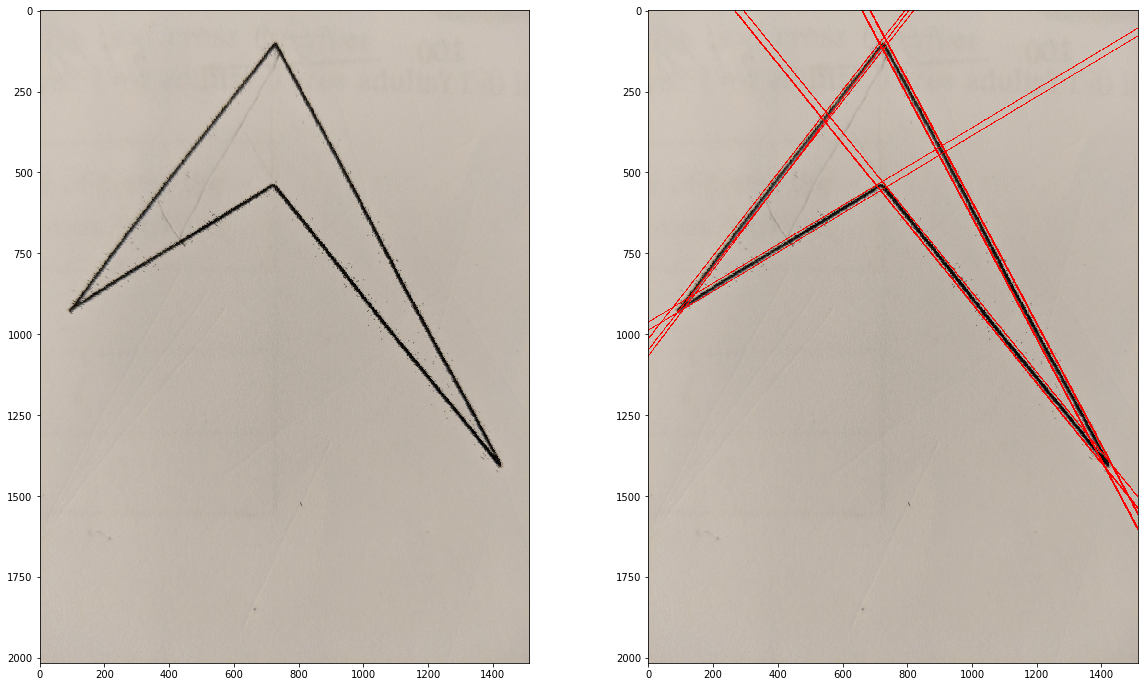

In [463]:
hough_lines_plot('lines.jpg', out, 250, angles)

### So we now have a function to create houghspace and then a plotting one as well. Let's just put cherry on the cake by creating a Command Line Input

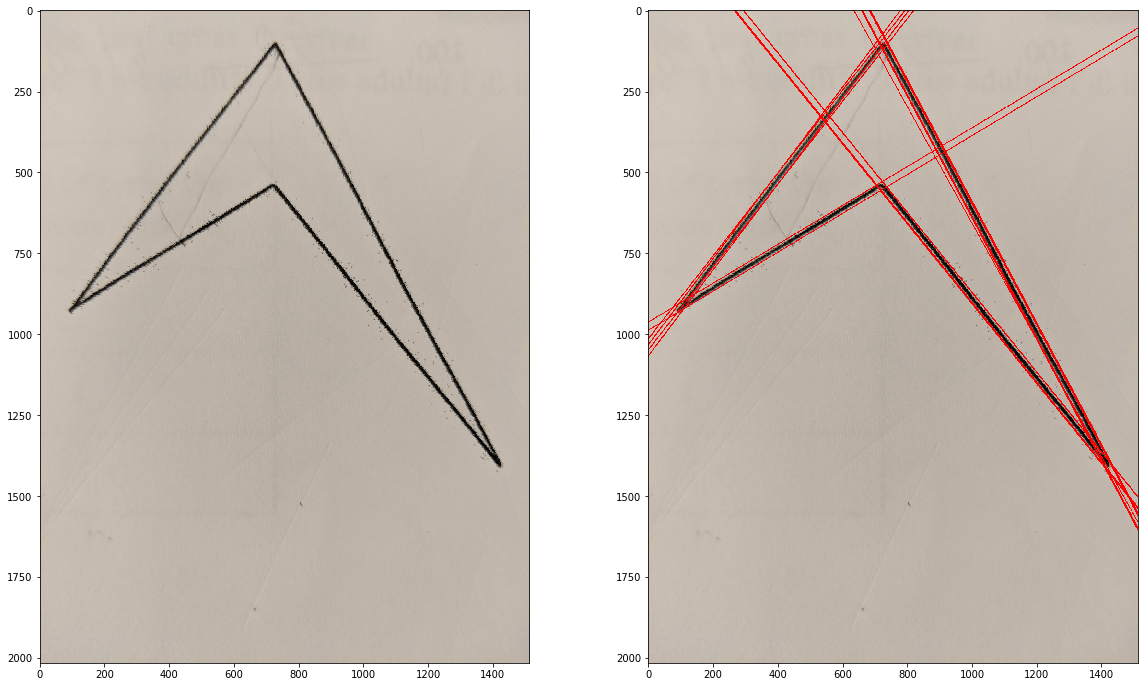

In [348]:
if __name__ == "__main__":
#     image = cv2.imread("lines.jpg",0)
#     edge_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
#     edge_image = cv2.Canny(edge_image, 100, 200)
#     edge_image = cv2.dilate(edge_image, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations=1)
#     edge_image = cv2.erode(edge_image, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations=1)
    
    image = cv2.imread("lines.jpg",0)
    image = cv2.GaussianBlur(image, (3,3), 0)
    ret, image = cv2.threshold(image, 90, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(image, kernel, iterations=1)

    edges = feature.canny(erosion, sigma=10)
    
    edge_image = edges.astype('float16')

    angles = np.radians(np.arange(-90, 91, 1))
    out, dist = hough_line_func(edge_image, angles)
    
    hough_lines_plot('lines.jpg', out, 250)

### And lastly we are going to try it in a whole unseen image:

Step1: Blurring the image - done
Step2: Thresholding - done
Step3: Erosion - done


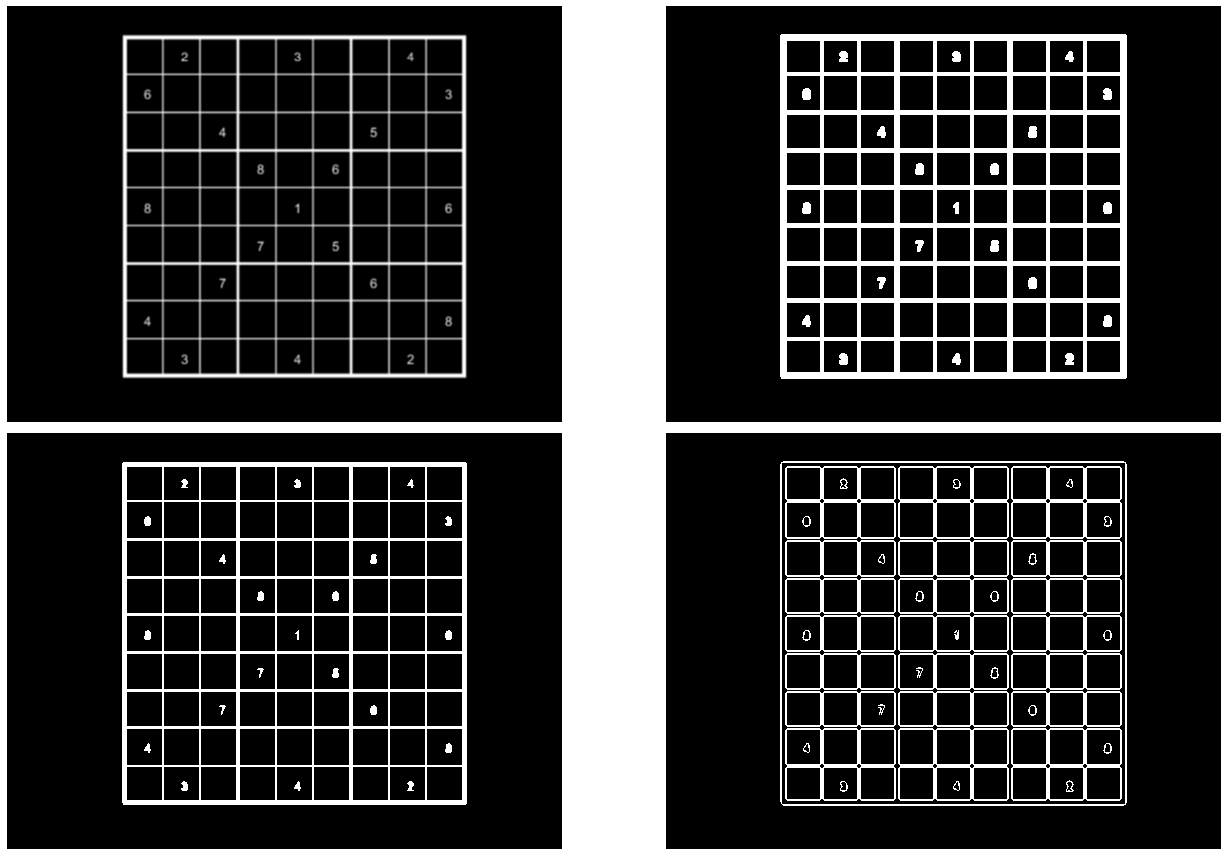

Step4: Edges - done
Step5: Lines - done


C:\Users\amit.amola\AppData\Local\Continuum\anaconda3\envs\cv_nn\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


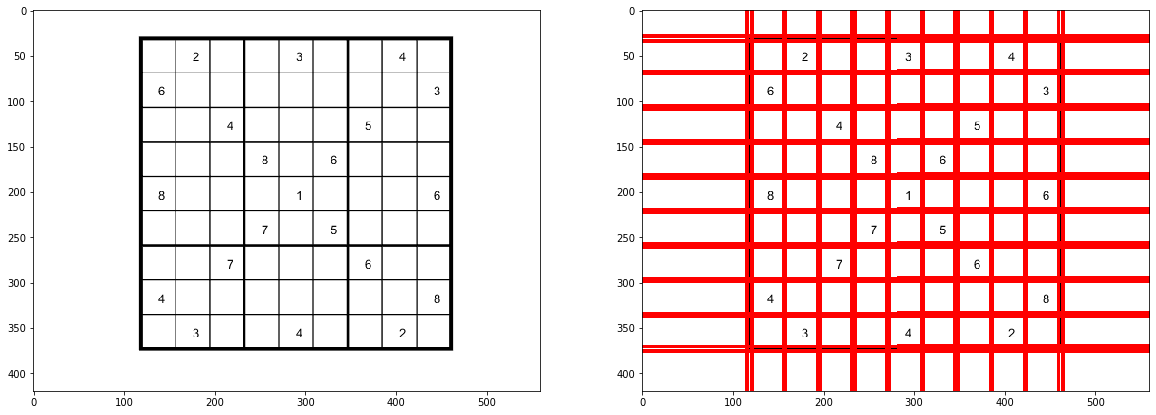

Finished.


In [574]:
if __name__ == "__main__":
    image = cv2.imread("sud.png",0)
    image = cv2.bitwise_not(image)
    
    plt.figure(figsize=(20,12))
    
    image = cv2.GaussianBlur(image, (3,3), 0)
    print('Step1: Blurring the image - done')
    
    plt.subplot(221)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    ret, image = cv2.threshold(image, 200, 255, cv2.THRESH_TRIANGLE)
    print('Step2: Thresholding - done')
    
    plt.subplot(222)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(image, kernel, iterations=1)
    print('Step3: Erosion - done')
    
    plt.subplot(223)
    plt.imshow(cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    edges = canny(erosion, sigma=0.1)
#     edges = erosion.copy()
    
    plt.subplot(224)
    plt.imshow(edges, 'gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    edge_image = edges.astype('float16')
    print('Step4: Edges - done')
    
    angles = np.radians(np.arange(-90, 91, 1))
    out, dist = hough_line_func(edge_image, angles)
    print('Step5: Lines - done')
        
    hough_lines_plot('sud.png', out, 300, angles)
    print('Finished.')

### Using method from OpenCV

### The probabilistic method

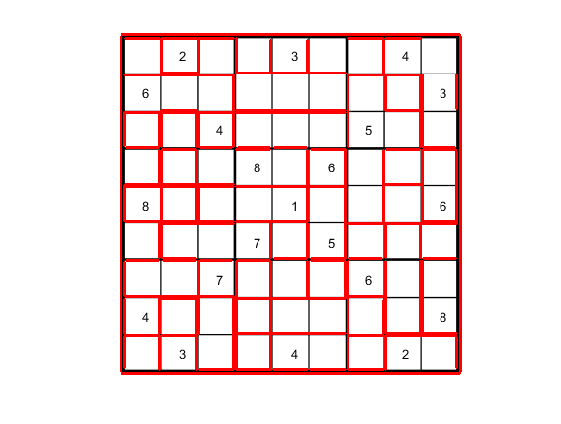

In [442]:
img = cv2.imread('sud.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
minLineLength = 10
maxLineGap = 10

lines = cv2.HoughLinesP(edges, 0.1, np.pi/180, 100, minLineLength, maxLineGap)
for x1,y1,x2,y2 in np.squeeze(lines):
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

plt.figure(figsize=(15,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()


### Hough space method

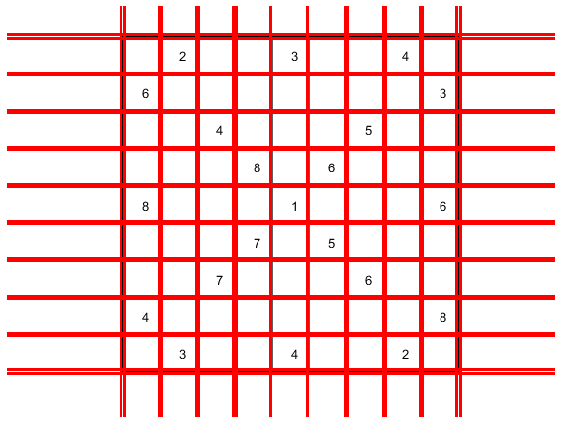

In [429]:
img = cv2.imread('sud.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,200)
for rho,theta in np.squeeze(lines):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

plt.figure(figsize=(15,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()

### That's it from my end. Not going into more detail of how to make it work from pixel to pixel level line only and not on the whole image. Will do it some other day.